In [ ]:
# Bug Report Classification with RoBERTa
# A Google Colab notebook for Intelligent Software Engineering Tool Building Project

# ======================================================
# Cell 1: Mount Google Drive and Setup Directory Structure
# ======================================================
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Set up your project directory structure in Google Drive
BASE_DIR = '/content/drive/MyDrive/BugReportClassification'
DATA_DIR = f'{BASE_DIR}/data'
MODELS_DIR = f'{BASE_DIR}/models'
RESULTS_DIR = f'{BASE_DIR}/results'

# Create directories if they don't exist
for directory in [BASE_DIR, DATA_DIR, MODELS_DIR, RESULTS_DIR]:
    if not os.path.exists(directory):
        os.makedirs(directory)

print(f"Project directories set up at: {BASE_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project directories set up at: /content/drive/MyDrive/BugReportClassification


In [ ]:
# ======================================================
# Cell 2: Install Required Packages
# ======================================================
!pip uninstall -y numpy transformers datasets pandas torch scikit-learn nltk matplotlib seaborn tqdm

!pip install transformers datasets scikit-learn pandas numpy matplotlib seaborn torch nltk tqdm

Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
Found existing installation: transformers 4.36.2
Uninstalling transformers-4.36.2:
  Successfully uninstalled transformers-4.36.2
Found existing installation: datasets 2.16.1
Uninstalling datasets-2.16.1:
  Successfully uninstalled datasets-2.16.1
Found existing installation: pandas 1.5.3
Uninstalling pandas-1.5.3:
  Successfully uninstalled pandas-1.5.3
Found existing installation: torch 2.1.2
Uninstalling torch-2.1.2:
  Successfully uninstalled torch-2.1.2
Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: nltk 3.8.1
Uninstalling nltk-3.8.1:
  Successfully uninstalled nltk-3.8.1
Found existing installation: matplotlib 3.7.1
Uninstalling matplotlib-3.7.1:
  Successfully uninstalled matplotlib-3.7.1
Found existing installation: seaborn 0.12.2
Uninstalling seaborn-0.12.2:
  Su

In [ ]:
# ======================================================
# Cell 3: Import Required Libraries
# ======================================================
import pandas as pd
import numpy as np
import re
import math
import torch
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_curve, auc, confusion_matrix,
                             classification_report)

from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW

nltk.download('stopwords')
from nltk.corpus import stopwords

import random
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# ======================================================
# Cell 4: Define Text Preprocessing Methods
# ======================================================
def remove_html(text):
    """Remove HTML tags using a regex."""
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

def remove_emoji(text):
    """Remove emojis using a regex pattern."""
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F1E0-\U0001F1FF"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

NLTK_stop_words_list = stopwords.words('english')
custom_stop_words_list = ['...']
final_stop_words_list = NLTK_stop_words_list + custom_stop_words_list

def remove_stopwords(text):
    """Remove stopwords from the text."""
    return " ".join([word for word in str(text).split() if word not in final_stop_words_list])

def clean_str(string):
    """
    Clean text by removing non-alphanumeric characters,
    and convert it to lowercase.
    """
    string = re.sub(r"[^A-Za-z0-9(),.!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"\)", " ) ", string)
    string = re.sub(r"\?", " ? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

def preprocess_text(data, text_col):
    """Apply all preprocessing steps to the text data."""
    data[text_col] = data[text_col].apply(remove_html)
    data[text_col] = data[text_col].apply(remove_emoji)
    data[text_col] = data[text_col].apply(remove_stopwords)
    data[text_col] = data[text_col].apply(clean_str)
    return data

In [ ]:
# ======================================================
# Cell 5: Data Loading and Preprocessing Function
# ======================================================
def load_and_preprocess_data(project_name):
    """
    Load and preprocess data for a specific project.

    Args:
        project_name (str): Name of the project (e.g., 'caffe', 'pytorch')

    Returns:
        pandas.DataFrame: Preprocessed data with 'text' and 'sentiment' columns
    """

    path = f'{DATA_DIR}/{project_name}.csv'

    # Load data
    pd_all = pd.read_csv(path)
    pd_all = pd_all.sample(frac=1, random_state=999)

    # Merge Title and Body into a single column; if Body is NaN, use Title only
    pd_all['Title+Body'] = pd_all.apply(
        lambda row: row['Title'] + '. ' + row['Body'] if pd.notna(row['Body']) else row['Title'],
        axis=1
    )

    # Keep only necessary columns: id, Number, sentiment, text (merged Title+Body)
    pd_tplusb = pd_all.rename(columns={
        "Unnamed: 0": "id",
        "class": "sentiment",
        "Title+Body": "text"
    })

    # Preprocess text
    pd_tplusb = preprocess_text(pd_tplusb, 'text')

    return pd_tplusb

In [ ]:
# ======================================================
# Cell 6: RoBERTa Dataset and Tokenization
# ======================================================
class BugReportDataset(torch.utils.data.Dataset):
    """Dataset for bug report classification with RoBERTa."""

    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# ======================================================
# Cell 7: RoBERTa Training Function
# ======================================================
def train_roberta_model(data, project_name, epochs=4, batch_size=16, repeat=10):
    """
    Train a RoBERTa model for bug report classification

    Args:
        data (pandas.DataFrame): Preprocessed data with 'text' and 'sentiment' columns
        project_name (str): Name of the project
        epochs (int): Number of training epochs
        batch_size (int): Batch size for training
        repeat (int): Number of repeats for the experiment

    Returns:
        dict: Dictionary with metrics on the test set
    """

    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    auc_values = []

    for rep in range(repeat):
        print(f"\nRepeat {rep+1}/{repeat}")


        train_data, test_data = train_test_split(
            data, test_size=0.2, random_state=rep
        )


        tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
        model = RobertaForSequenceClassification.from_pretrained(
            'roberta-base',
            num_labels=2,
            output_attentions=False,
            output_hidden_states=False
        )

        # Move model to device
        model = model.to(device)

        # Create datasets
        train_dataset = BugReportDataset(
            train_data['text'],
            train_data['sentiment'],
            tokenizer
        )

        test_dataset = BugReportDataset(
            test_data['text'],
            test_data['sentiment'],
            tokenizer
        )

        train_dataloader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True
        )

        test_dataloader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=batch_size
        )

        optimizer = AdamW(
            model.parameters(),
            lr=2e-5,
            eps=1e-8
        )

        total_steps = len(train_dataloader) * epochs

        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
        )

        # Training loop
        print(f"Starting RoBERTa training for repeat {rep+1}...")

        for epoch in range(epochs):
            # Training
            model.train()
            total_train_loss = 0

            for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
                # Move tensors to device
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                # Clear previous gradients
                model.zero_grad()

                # Forward pass
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                loss = outputs.loss
                total_train_loss += loss.item()

                # Backward pass
                loss.backward()

                # Clip gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

                # Update parameters
                optimizer.step()

                # Update learning rate
                scheduler.step()

            # Calculate average loss
            avg_train_loss = total_train_loss / len(train_dataloader)
            print(f"Average training loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()

        # Track predictions, probabilities, and true labels
        predictions = []
        prediction_probs = []
        true_labels = []

        # Evaluate without gradient calculations
        with torch.no_grad():
            for batch in tqdm(test_dataloader, desc="Evaluating"):
                # Move tensors to device
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                # Forward pass
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )

                # Get predictions
                logits = outputs.logits
                # Get probability scores for the positive class (class 1)
                probs = torch.nn.functional.softmax(logits, dim=1)[:, 1].cpu().numpy()
                preds = torch.argmax(logits, dim=1).cpu().numpy()

                # Add batch predictions, probabilities, and labels to lists
                predictions.extend(preds)
                prediction_probs.extend(probs)
                true_labels.extend(labels.cpu().numpy())

        # Convert predictions and true labels to numpy arrays
        predictions = np.array(predictions)
        prediction_probs = np.array(prediction_probs)
        true_labels = np.array(true_labels)

        # Calculate metrics
        accuracy = accuracy_score(true_labels, predictions)
        precision = precision_score(true_labels, predictions, average='macro')
        recall = recall_score(true_labels, predictions, average='macro')
        f1 = f1_score(true_labels, predictions, average='macro')
        # Use probability scores for ROC and AUC calculation
        fpr, tpr, _ = roc_curve(true_labels, prediction_probs, pos_label=1)
        auc_val = auc(fpr, tpr)

        # Store metrics
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        auc_values.append(auc_val)

        # Print metrics for this repeat
        print(f"\nRepeat {rep+1} Results:")
        print(f"Accuracy:      {accuracy:.4f}")
        print(f"Precision:     {precision:.4f}")
        print(f"Recall:        {recall:.4f}")
        print(f"F1 score:      {f1:.4f}")
        print(f"AUC:           {auc_val:.4f}")

        # Save model for the last repeat
        if rep == repeat - 1:
            # Plot confusion matrix
            cm = confusion_matrix(true_labels, predictions)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.title('Confusion Matrix')
            plt.savefig(f'{RESULTS_DIR}/{project_name}_roberta_cm.png')
            plt.show()

            # Save model
            model_path = f'{MODELS_DIR}/{project_name}_roberta_model'
            model.save_pretrained(model_path)
            tokenizer.save_pretrained(model_path)
            print(f"Model saved to {model_path}")

    # Calculate average metrics across all repeats
    final_accuracy = np.mean(accuracies)
    final_precision = np.mean(precisions)
    final_recall = np.mean(recalls)
    final_f1 = np.mean(f1_scores)
    final_auc = np.mean(auc_values)

    # Print final metrics
    print("\n=== RoBERTa Model Results (Average across repeats) ===")
    print(f"Number of repeats:     {repeat}")
    print(f"Average Accuracy:      {final_accuracy:.4f}")
    print(f"Average Precision:     {final_precision:.4f}")
    print(f"Average Recall:        {final_recall:.4f}")
    print(f"Average F1 score:      {final_f1:.4f}")
    print(f"Average AUC:           {final_auc:.4f}")

    cv_auc_list = [float(val) for val in auc_values]

    metrics_df = pd.DataFrame(
        {
            'repeated_times': [repeat],
            'Accuracy': [float(final_accuracy)],
            'Precision': [float(final_precision)],
            'Recall': [float(final_recall)],
            'F1': [float(final_f1)],
            'AUC': [float(final_auc)],
            'CV_list(AUC)': [str(cv_auc_list)]
        }
    )

    metrics_path = f'{RESULTS_DIR}/{project_name}_NB.csv'
    metrics_df.to_csv(metrics_path, index=False)
    print(f"Metrics saved to {metrics_path}")

    return {
        'accuracy': final_accuracy,
        'precision': final_precision,
        'recall': final_recall,
        'f1': final_f1,
        'auc': final_auc
    }

Data loaded and preprocessed. Shape: (752, 13)

Repeat 1/10


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting RoBERTa training for repeat 1...


Epoch 1/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.4072


Epoch 2/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.3163


Epoch 3/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.2065


Epoch 4/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.1832


Epoch 5/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.1118


Epoch 6/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0604


Epoch 7/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0560


Epoch 8/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0367


Epoch 9/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0295


Epoch 10/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0295


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]


Repeat 1 Results:
Accuracy:      0.8742
Precision:     0.7162
Recall:        0.7845
F1 score:      0.7424
AUC:           0.9348

Repeat 2/10


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting RoBERTa training for repeat 2...


Epoch 1/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.3913


Epoch 2/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.2809


Epoch 3/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.1813


Epoch 4/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.1315


Epoch 5/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0868


Epoch 6/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0296


Epoch 7/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0051


Epoch 8/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0035


Epoch 9/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0009


Epoch 10/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0011


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]


Repeat 2 Results:
Accuracy:      0.8808
Precision:     0.8363
Recall:        0.7337
F1 score:      0.7692
AUC:           0.8368

Repeat 3/10


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting RoBERTa training for repeat 3...


Epoch 1/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.4271


Epoch 2/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.2927


Epoch 3/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.2276


Epoch 4/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.1539


Epoch 5/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.1643


Epoch 6/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0601


Epoch 7/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0472


Epoch 8/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0327


Epoch 9/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0217


Epoch 10/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0153


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]


Repeat 3 Results:
Accuracy:      0.8609
Precision:     0.6952
Recall:        0.6868
F1 score:      0.6908
AUC:           0.8992

Repeat 4/10


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting RoBERTa training for repeat 4...


Epoch 1/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.4037


Epoch 2/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.3148


Epoch 3/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.2400


Epoch 4/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.1839


Epoch 5/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.1592


Epoch 6/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.1184


Epoch 7/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0393


Epoch 8/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0164


Epoch 9/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0125


Epoch 10/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0101


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]


Repeat 4 Results:
Accuracy:      0.8940
Precision:     0.7817
Recall:        0.7588
F1 score:      0.7695
AUC:           0.9110

Repeat 5/10


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting RoBERTa training for repeat 5...


Epoch 1/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.4090


Epoch 2/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.2975


Epoch 3/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.1856


Epoch 4/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.1065


Epoch 5/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0580


Epoch 6/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0163


Epoch 7/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0170


Epoch 8/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0129


Epoch 9/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0062


Epoch 10/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0047


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]


Repeat 5 Results:
Accuracy:      0.8874
Precision:     0.7883
Recall:        0.7979
F1 score:      0.7929
AUC:           0.8809

Repeat 6/10


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting RoBERTa training for repeat 6...


Epoch 1/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.4323


Epoch 2/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.3200


Epoch 3/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.2195


Epoch 4/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.1710


Epoch 5/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.1291


Epoch 6/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0653


Epoch 7/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0252


Epoch 8/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0136


Epoch 9/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0084


Epoch 10/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0074


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]


Repeat 6 Results:
Accuracy:      0.9338
Precision:     0.7829
Recall:        0.8593
F1 score:      0.8150
AUC:           0.9247

Repeat 7/10


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting RoBERTa training for repeat 7...


Epoch 1/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.4399


Epoch 2/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.3182


Epoch 3/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.2147


Epoch 4/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.1787


Epoch 5/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.1161


Epoch 6/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0802


Epoch 7/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0417


Epoch 8/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0213


Epoch 9/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0136


Epoch 10/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0080


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]


Repeat 7 Results:
Accuracy:      0.9338
Precision:     0.8218
Recall:        0.8856
F1 score:      0.8495
AUC:           0.9631

Repeat 8/10


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting RoBERTa training for repeat 8...


Epoch 1/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.4345


Epoch 2/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.3248


Epoch 3/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.2190


Epoch 4/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.1910


Epoch 5/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.1398


Epoch 6/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0970


Epoch 7/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0476


Epoch 8/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0270


Epoch 9/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0112


Epoch 10/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0089


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]


Repeat 8 Results:
Accuracy:      0.9470
Precision:     0.8796
Recall:        0.8796
F1 score:      0.8796
AUC:           0.9370

Repeat 9/10


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting RoBERTa training for repeat 9...


Epoch 1/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.4123


Epoch 2/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.2861


Epoch 3/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.1953


Epoch 4/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.1163


Epoch 5/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0778


Epoch 6/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0408


Epoch 7/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0138


Epoch 8/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0069


Epoch 9/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0047


Epoch 10/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0030


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]


Repeat 9 Results:
Accuracy:      0.8675
Precision:     0.6963
Recall:        0.7327
F1 score:      0.7118
AUC:           0.9102

Repeat 10/10


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting RoBERTa training for repeat 10...


Epoch 1/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.4034


Epoch 2/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.3546


Epoch 3/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.2385


Epoch 4/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.1608


Epoch 5/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0849


Epoch 6/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0447


Epoch 7/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0140


Epoch 8/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0087


Epoch 9/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0074


Epoch 10/10:   0%|          | 0/38 [00:00<?, ?it/s]

Average training loss: 0.0037


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]


Repeat 10 Results:
Accuracy:      0.9404
Precision:     0.8289
Recall:        0.8483
F1 score:      0.8382
AUC:           0.9691


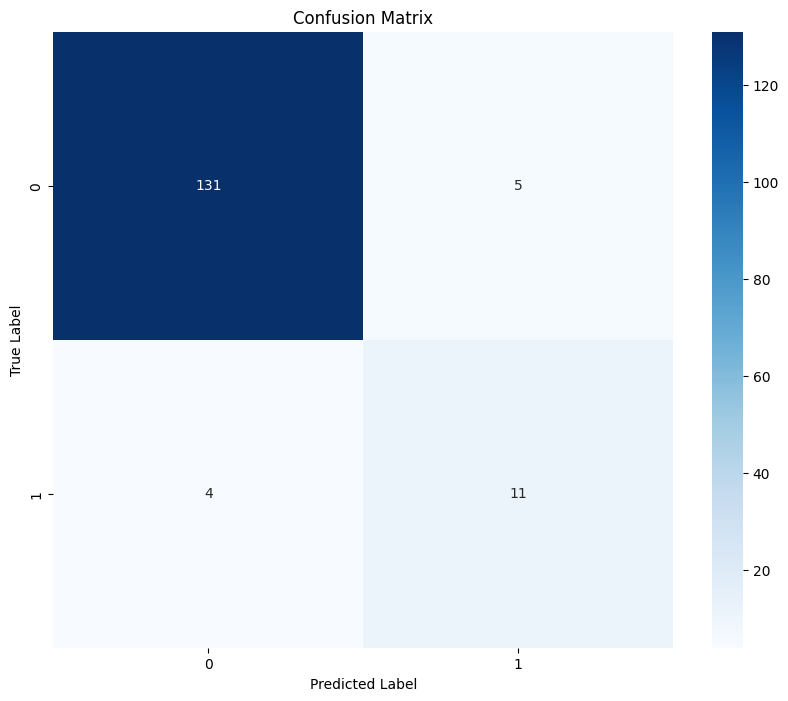

Model saved to /content/drive/MyDrive/BugReportClassification/models/pytorch_roberta_model

=== RoBERTa Model Results (Average across repeats) ===
Number of repeats:     10
Average Accuracy:      0.9020
Average Precision:     0.7827
Average Recall:        0.7967
Average F1 score:      0.7859
Average AUC:           0.9167
Metrics saved to /content/drive/MyDrive/BugReportClassification/results/pytorch_NB.csv


In [ ]:
# ======================================================
# Cell 8: Run the Experiment for a Single Project
# ======================================================
# Choose a project to run the experiment on
project_name = 'pytorch'  # You can change this to 'pytorch', 'caffe', 'tensorflow', 'keras', or 'incubator-mxnet. Depending on which dataset you want to run it on'

import shutil
for file in ['caffe.csv', 'tensorflow.csv', 'keras.csv', 'pytorch.csv', 'incubatormxnet.csv']:
    source_path = f'/content/{file}'
    target_path = f'{DATA_DIR}/{file}'

    # Rename incubatormxnet.csv to incubator-mxnet.csv for consistency
    if file == 'incubatormxnet.csv':
        target_path = f'{DATA_DIR}/incubator-mxnet.csv'

    try:
        if os.path.exists(source_path):
            if not os.path.exists(target_path):
                shutil.copy(source_path, target_path)
                print(f"Copied {file} to {target_path}")
        else:
            print(f"Warning: {file} not found in Colab. Please upload it manually to {DATA_DIR}")
    except Exception as e:
        print(f"Error copying {file}: {e}")

# Load and preprocess data
data = load_and_preprocess_data(project_name)
print(f"Data loaded and preprocessed. Shape: {data.shape}")

# Train RoBERTa model with 10 repeats
roberta_metrics = train_roberta_model(
    data=data,
    project_name=project_name,
    epochs=10,
    batch_size=16,
    repeat=10
)